In [107]:
# Importing essential libraries and functions

import pandas as pd
import numpy as np

import re

In [108]:
import tensorflow as tf

In [109]:
import matplotlib.pyplot as plt

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import nltk 
from nltk.corpus import stopwords
from numpy import array

Num GPUs Available:  1


In [110]:

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [111]:
movie_reviews = pd.read_csv("IMDB_Dataset.csv")

In [112]:
movie_reviews.shape

(50000, 2)

In [113]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


<Axes: xlabel='sentiment', ylabel='count'>

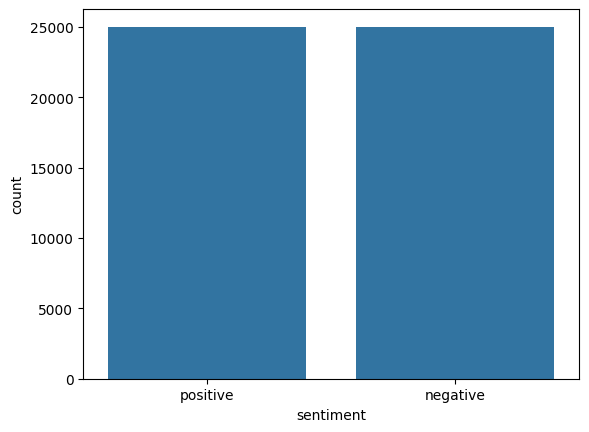

In [114]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

 The data we have is balanced

In [115]:
movie_reviews['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [116]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/underdog/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [117]:
stopwords_list = set(stopwords.words('english'))

In [118]:
import re

def preprocess(text):
    text = re.sub(r'<.*?>', '', text)
    text = text.lower()
        
        # Remove html tags
    

        # Remove punctuations and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
        
        # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

        # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.
        
        # Remove Stopwords

    words = text.split()  # Split the text into words
    filtered_words = [word for word in words if word not in stopwords_list]
    return ' '.join(filtered_words)
   

#review = remove_html_tags(movie_reviews['review'][0])


In [119]:
movie_reviews['sentiment'][0]

'positive'

In [120]:
X = []
for review in movie_reviews['review']:
    X.append(preprocess(review))
X[0]

'one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skill

In [121]:
len(X)

50000

In [122]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the labels
y = label_encoder.fit_transform(movie_reviews['sentiment'])

y[0]  # Output: [1 0 1 0]


np.int64(1)

In [123]:
len(y)

50000

In [124]:
y=np.array(y)

In [125]:
# Tokenize the text data
max_words = 18000  # Maximum vocabulary size
max_len = 200  # Maximum length of sequences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

# Pad sequences to ensure uniform length
X = pad_sequences(sequences, maxlen=max_len)

# Convert labels to numpy array



Found 101245 unique tokens.


In [126]:
embedding_dim = 200  # You can choose 50, 100, 200, or 300-dimensional embeddings
embeddings_index = {}
with open("glove.6B/glove.6B.200d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Prepare the embedding matrix
word_index = tokenizer.word_index  # Tokenizer from Keras
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [128]:
y_train.shape

(40000,)

In [129]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False)) 
#model.add(LSTM(units=128, return_sequences=True))# Set trainable=True if you want to fine-tune the embeddings
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Compile the model
model.build(input_shape=(None, max_len))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 200, 200)       │    20,249,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       168,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,417,777 (77.89 MB)

 Trainable params: 168,577 (658.50 KB)

 Non-trainable params: 20,249,200 (77.24 MB)

None


Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.7673 - loss: 0.4794 - val_accuracy: 0.8534 - val_loss: 0.3393
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.8636 - loss: 0.3249 - val_accuracy: 0.8655 - val_loss: 0.3223
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.8864 - loss: 0.2748 - val_accuracy: 0.8804 - val_loss: 0.2864
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.9068 - loss: 0.2350 - val_accuracy: 0.8869 - val_loss: 0.2766
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.9212 - loss: 0.1979 - val_accuracy: 0.8882 - val_loss: 0.2875


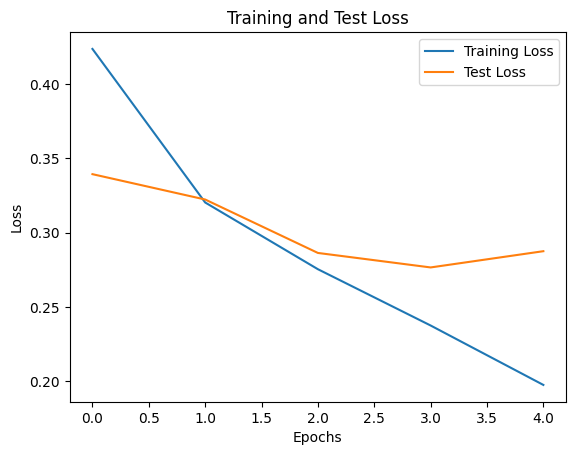

In [130]:
np.random.seed(12)
batch_size = 32
epochs = 5

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

In [131]:
# Evaluate on test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Test Accuracy: 88.63%
